In [1]:
println("Hello super people!")

Hello super people!


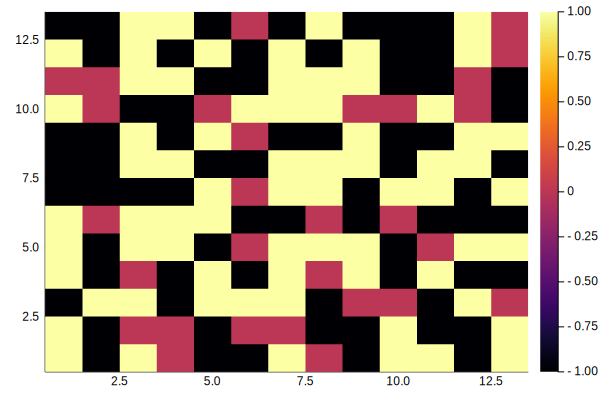

In [35]:
#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = 13*13

yellow_count = Int(round(CELL_COUNT * 5/12))
blue_count = Int(round(CELL_COUNT * 5/12))    
empty_grid = zeros(GRID_SIZE,GRID_SIZE)

empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

using Random

start_grid = shuffle(empty_grid)


using Plots
heatmap(start_grid)




In [32]:
using Plots




In [9]:
using Documenter


┌ Info: Precompiling Documenter [e30172f5-a6a5-5a46-863b-614d45cd2de4]
└ @ Base loading.jl:1186


$$\lambda + \beta$$
$$\frac{12}{4}$$

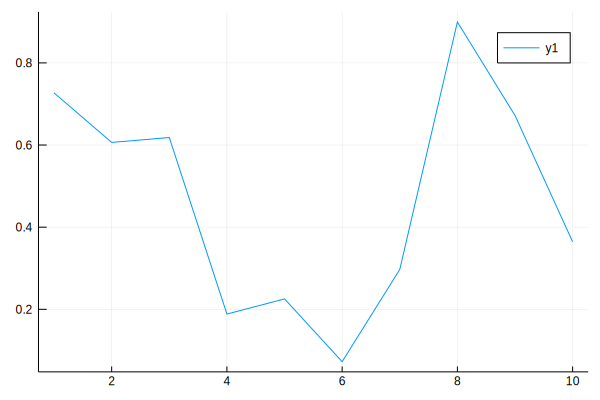

In [16]:
using Plots
plot(rand(10))

In [17]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [18]:
x=3
println(f1(x))

18
